In [2]:

import time
import numpy as np
import cv2
import scipy.special
import matplotlib.pyplot as plt
import os
import csv

from os import listdir
from os.path import isfile, join
import pandas
from scipy import ndimage
import random

In [3]:
def to_crop_img(image):
  #image = cv2.imread(img_name)


  img = image.copy()
  image = cv2.resize(img,(len(img[0])//5,len(img)//5))

  img = cv2.blur(img,(15,15))

  img = cv2.resize(img,(len(img[0])//5,len(img)//5))

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Find Canny edges
  #edged = cv2.Canny(img, 25, 250)
  edged = cv2.threshold(img, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


  contours, hierarchy = cv2.findContours(edged, 
      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  max_position = 0
  max_value = 0
  for i in range(len(contours)):
      #print(contours[i].shape)
      if(contours[i].shape[0]>max_value):
          max_value = contours[i].shape[0]
          max_position = i
          

  x,y,w,h = cv2.boundingRect(contours[max_position])
  #print(w,' ',h,' ',w/h)
  crop_img = image[y:y+h, x:x+w]

  if(w/h > 0.59):
      rotate = ndimage.rotate(crop_img, 0-((w/h-0.54)*100),cval=205.0)
      img_rotate = cv2.blur(rotate,(1,1))
      img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
      rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
      #cv2.imshow('img_rotate',rotate_edged)
      contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      max_position_rotate = 0
      max_value_rotate = 0
      for i in range(len(contours_rotate)):
          #print(contours[i].shape)
          if(contours_rotate[i].shape[0]>max_value_rotate):
              max_value_rotate = contours_rotate[i].shape[0]
              max_position_rotate = i
      x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
      crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
      #print(w_rotate/h_rotate)
      ratio_unclockwise = w_rotate/h_rotate
      if(w_rotate/h_rotate >0.59):
          rotate = ndimage.rotate(crop_img, ((w/h-0.57)*100),cval=205.0)
          img_rotate = cv2.blur(rotate,(1,1))
          img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
          rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
          #cv2.imshow('img_rotate',rotate_edged)
          contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          max_position_rotate = 0
          max_value_rotate = 0
          for i in range(len(contours_rotate)):
              #print(contours[i].shape)
              if(contours_rotate[i].shape[0]>max_value_rotate):
                  max_value_rotate = contours_rotate[i].shape[0]
                  max_position_rotate = i
          x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
          crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
          #print(w_rotate/h_rotate)
          ratio_clockwise = w_rotate/h_rotate
          if (ratio_clockwise>ratio_unclockwise):
            rotate = ndimage.rotate(crop_img, 0-((w/h-0.54)*100),cval=205.0)
            img_rotate = cv2.blur(rotate,(1,1))
            img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
            rotate_edged = cv2.threshold(img_rotate, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            #cv2.imshow('img_rotate',rotate_edged)
            contours_rotate, hierarchy_rotate = cv2.findContours(rotate_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            max_position_rotate = 0
            max_value_rotate = 0
            for i in range(len(contours_rotate)):
                #print(contours[i].shape)
                if(contours_rotate[i].shape[0]>max_value_rotate):
                    max_value_rotate = contours_rotate[i].shape[0]
                    max_position_rotate = i
            x_rotate,y_rotate,w_rotate,h_rotate = cv2.boundingRect(contours_rotate[max_position_rotate])
            crop_img_rotate = rotate[y_rotate:y_rotate+h_rotate, x_rotate:x_rotate+w_rotate]
            #print(w_rotate/h_rotate)
      #cv2.imshow('rotate',crop_img_rotate)
      crop_img = crop_img_rotate #
  return crop_img

In [4]:
def avg_in_scale(crop_img):
  crop_img = img = cv2.resize(crop_img,(275,512))
  avg_scale_from_crop = []
  count = 0
  for row_line in range(len(crop_img)//30-2):
    for col_line in range(len(crop_img[0])//30-2):
      img_scale = crop_img[(row_line+1)*30:(row_line+1)*30+30, (col_line+1)*30:(col_line+1)*30+30]
      avg_pix = 0
      for row in range(len(img_scale)):
        for col in range(len(img_scale[0])):
          avg_pix += sum(img_scale[row][col])/3
      avg_scale_from_crop.append(avg_pix)
      count+=1
  if (count<105):
    for i in range(105-count):
      avg_scale_from_crop.append(0)
  elif (count>105):
    for i in range(count-105):
      avg_scale_from_crop.pop()

  return np.array(avg_scale_from_crop)

In [5]:
# neural network class definition
class neuralNetwork :

    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes,learningrate,hiddenlayer) :

        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        self.num_hiddenlayer = hiddenlayer

        #set weight
        self.set_w  = []
        #self.w = np.random.normal(0.0, pow(self.onodes, -0.5),(self.onodes, self.inodes))
        self.set_w.append(np.random.normal(0.0, pow(self.inodes, -0.5),(self.hnodes, self.inodes)))
        for i in range(self.num_hiddenlayer-1):
            self.set_w.append(np.random.normal(0.0, pow(self.hnodes, -0.5),(self.hnodes, self.hnodes)))
        self.set_w.append(np.random.normal(0.0, pow(self.hnodes, -0.5),(self.onodes, self.hnodes)))
        self.set_w = np.array(self.set_w)

        # learning rate
        self.lr = learningrate
        self.bias = []
        for i in range(self.num_hiddenlayer+1):
            self.bias.append(1)
        self.bias = np.array(self.bias)
        

        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        #self.derivative_function = lambda x: 1 if x>0 else 0 if x==0 else -1

        pass
   
    

    # train the neural network
    def train(self, inputs_list, targets_list) :
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        # print('targets = ', targets)

        result_each_layer_set = []
        # w_dot_input = np.dot(self.w, inputs)
        # outputs = self.activation_function(w_dot_input+1)
        result_each_layer_set.append(self.activation_function(np.dot(self.set_w[0], inputs)+self.bias[0]))
        for i in range(self.num_hiddenlayer):
            result_each_layer_set.append(self.activation_function(np.dot(self.set_w[i+1], result_each_layer_set[i])+self.bias[i+1]))
        

        # output layer error is the (target actual)
        #output_errors = targets-outputs
        error_set = []
        output_errors = targets-result_each_layer_set[-1]
        
        error_set.append(output_errors)
        for i in range(self.num_hiddenlayer):
            error_set.append(np.dot(self.set_w[0-(i+1)].T,error_set[i]))
        
        # print(error_set)
        # print(self.set_w)



        
        
        # update the weights 
       
        # self.w += self.lr * np.dot((output_errors*outputs * (1.0-outputs)),np.transpose(inputs)) 
        for i in range(len(error_set)-1):
            self.set_w[0-(i+1)] += self.lr * np.dot((error_set[i] * result_each_layer_set[0-(i+1)] * (1.0 - result_each_layer_set[0-(i+1)])), np.transpose(result_each_layer_set[0-(i+2)]))
            self.bias[0-(i+1)] +=  self.lr*self.bias[0-(i+1)] *sum(error_set[i] * result_each_layer_set[0-(i+1)] * (1.0 - result_each_layer_set[0-(i+1)]))
        self.set_w[0] += self.lr * np.dot((error_set[-1] * result_each_layer_set[0] * (1.0 - result_each_layer_set[0])), np.transpose(inputs))
        self.bias[0] +=  self.lr *self.bias[0] *sum(error_set[-1] * result_each_layer_set[0] * (1.0 - result_each_layer_set[0]))
        


        # print("*********")
        pass

    # query the neural network
    def query(self, inputs_list) :

        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T


        # output = np.dot(self.w, inputs)

        # # calculate the signals emerging 
        # final_outputs = self.activation_function(output)

        result_each_layer_set = []
        result_each_layer_set.append(self.activation_function(np.dot(self.set_w[0], inputs)+self.bias[0]))
        for i in range(self.num_hiddenlayer):
            result_each_layer_set.append(self.activation_function(np.dot(self.set_w[i+1], result_each_layer_set[i])+self.bias[i+1]))
        
        final_outputs = result_each_layer_set[-1]

        return final_outputs
    
   
    # def write_weight(self) :
    #     f = open('who.txt','w',encoding='utf-8')
    #     f.write(str(self.who))
    #     f.close()
    #     f = open('wih.txt','w',encoding='utf-8')
    #     f.write(str(self.wih))
    #     f.close()
    #     print('already write!! ')
        

In [6]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/train_data_use_color2.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/train_data_use_color2.zip
   creating: train_data/
  inflating: train_data/maeyupa.0.jpg  
  inflating: train_data/maeyupa.1.jpg  
  inflating: train_data/maeyupa.100.jpg  
  inflating: train_data/maeyupa.101.jpg  
  inflating: train_data/maeyupa.108.jpg  
  inflating: train_data/maeyupa.109.jpg  
  inflating: train_data/maeyupa.110.jpg  
  inflating: train_data/maeyupa.111.jpg  
  inflating: train_data/maeyupa.112.jpg  
  inflating: train_data/maeyupa.113.jpg  
  inflating: train_data/maeyupa.12.jpg  
  inflating: train_data/maeyupa.120.jpg  
  inflating: train_data/maeyupa.121.jpg  
  inflating: train_data/maeyupa.122.jpg  
  inflating: train_data/maeyupa.123.jpg  
  inflating: train_data/maeyupa.124.jpg  
  inflating: train_data/maeyupa.125.jpg  
  inflating: train_data/maeyupa.13.jpg  
  inflating: train_data/maeyupa.1

In [7]:
mypath = 'train_data/'
imagePaths = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

In [8]:
train_list = []
train_list_ans = []

for (i, img_path) in enumerate(imagePaths):
      img = cv2.imread(img_path)
      crop_img = to_crop_img(img) 
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #train_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01)
      avg_img = avg_in_scale(crop_img)
      min_avg = min(avg_img)
      max_avg = max(avg_img)
      for i in range(len(avg_img)):
          avg_img[i] = (avg_img[i]-min_avg)/(max_avg-min_avg)
      train_list.append(avg_img)
      product_name = img_path.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4
      
      targets = np.zeros(4) + 0.01
      
      
      targets[product_class-1] = 0.99
      train_list_ans.append(targets)

              
      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


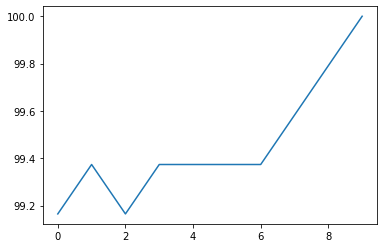

100.0
9


In [24]:

accuracy_each_epochs = []


input_nodes = 105
output_nodes = 4
hidden_nodes = 21

learning_rate = 0.1
hidden_layers = 1


###

n = neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate,hidden_layers)




epochs = 2500
for e in range(epochs):
    
    for i in range(len(train_list)):
        inputs =  train_list[i]        
        targets = train_list_ans[i]
        n.train(inputs, targets)
        pass
    pass

    #test
    
    scorecard = []

    # go through all the records in the test data set
    for  i in range(len(train_list)):
        inputs =  train_list[i]
        ans = np.argmax(train_list_ans[i])
      
               
        outputs = n.query(inputs)
        
        # the index of the highest value corresponds to the label
        label = np.argmax(outputs)

        
        # append correct or incorrect to list
        if (label == ans):
            
            scorecard.append(1)
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            scorecard.append(0)
            pass
        pass
    # calculate the performance score, the fraction of correct answers
    scorecard_array = np.asarray(scorecard)
    #print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)
    accuracy_each_epochs.append(scorecard_array.sum() /scorecard_array.size*100)
    if(scorecard_array.sum() /scorecard_array.size*100 == 100):
      break

plt.plot(np.arange(len(accuracy_each_epochs)),np.array(accuracy_each_epochs)) 
plt.show()
print(max(accuracy_each_epochs))
print(np.argmax(accuracy_each_epochs))

In [20]:
n.set_w

array([array([[ 1.03126822,  0.60902433,  0.22574505, ...,  0.47607918,
         0.41572087,  0.07501842],
       [-0.90584789, -0.5440346 , -0.20024249, ..., -0.7705376 ,
        -0.38025904, -0.03540927],
       [-0.31082502, -0.28559816, -0.02596143, ...,  0.27357497,
         0.53755961,  0.98826627],
       ...,
       [-0.21432486, -0.35331773, -0.26650896, ..., -0.85719736,
        -0.82542629, -1.12077794],
       [-1.28058744, -0.70199309, -0.1612745 , ..., -0.7285908 ,
        -0.59684511, -0.09062255],
       [ 0.26610127,  0.48733721,  0.30826646, ...,  0.20907037,
         0.39806849,  0.22832339]]),
       array([[ 0.76062545, -0.22280676, -1.14015383,  0.18026146,  1.44887839,
         0.15307731, -0.21549837, -0.21522855, -0.51853304,  0.8857935 ,
         0.65111913, -0.94738108, -0.41181432,  0.50278881,  0.03558979,
         0.05876595,  0.40946777,  0.73887815,  0.04633182, -1.08783329,
         1.00565921],
       [ 0.08475308, -0.12296658,  1.20353325,  0.18183436

In [11]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/test_data_use_color2.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/test_data_use_color2.zip
   creating: test_data/
  inflating: test_data/maeyupa.10.jpg  
  inflating: test_data/maeyupa.102.jpg  
  inflating: test_data/maeyupa.103.jpg  
  inflating: test_data/maeyupa.104.jpg  
  inflating: test_data/maeyupa.105.jpg  
  inflating: test_data/maeyupa.106.jpg  
  inflating: test_data/maeyupa.107.jpg  
  inflating: test_data/maeyupa.11.jpg  
  inflating: test_data/maeyupa.114.jpg  
  inflating: test_data/maeyupa.115.jpg  
  inflating: test_data/maeyupa.116.jpg  
  inflating: test_data/maeyupa.117.jpg  
  inflating: test_data/maeyupa.118.jpg  
  inflating: test_data/maeyupa.119.jpg  
  inflating: test_data/maeyupa.126.jpg  
  inflating: test_data/maeyupa.127.jpg  
  inflating: test_data/maeyupa.128.jpg  
  inflating: test_data/maeyupa.129.jpg  
  inflating: test_data/maeyupa.130.jpg  
  inflat

In [12]:
testpath = 'test_data/'
imageTestPaths = [testpath+f for f in listdir(testpath) if isfile(join(testpath, f))]

In [13]:
test_list = []
test_list_ans = []
for (i, img_path_test) in enumerate(imageTestPaths):
      img = cv2.imread(img_path_test)
      crop_img = to_crop_img(img)
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01)
      avg_img = avg_in_scale(crop_img)
      min_avg = min(avg_img)
      max_avg = max(avg_img)
      for i in range(len(avg_img)):
          avg_img[i] = (avg_img[i]-min_avg)/(max_avg-min_avg) 
      test_list.append(avg_img)
      product_name = img_path_test.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4

      test_list_ans.append(product_class-1)

In [25]:
fail_num = 1
scorecard = []
for  i in range(len(test_list)):
    inputs =  test_list[i]
    ans = test_list_ans[i]
  
            
    outputs = n.query(inputs)
    
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    
    # append correct or incorrect to list
    if (label == ans):
        
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        
        print(fail_num,' ',ans,' ',np.transpose(outputs))
        fail_num+=1
        pass
    pass
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)

performance =  100.0


In [15]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/"My Drive"/korat_sauce/test_after_train7.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/korat_sauce/test_after_train7.zip
   creating: test_after_train7/
  inflating: test_after_train7/maeyupa.0.jpg  
  inflating: test_after_train7/maeyupa.1.jpg  
  inflating: test_after_train7/maeyupa.10.jpg  
  inflating: test_after_train7/maeyupa.11.jpg  
  inflating: test_after_train7/maeyupa.12.jpg  
  inflating: test_after_train7/maeyupa.13.jpg  
  inflating: test_after_train7/maeyupa.14.jpg  
  inflating: test_after_train7/maeyupa.15.jpg  
  inflating: test_after_train7/maeyupa.16.jpg  
  inflating: test_after_train7/maeyupa.17.jpg  
  inflating: test_after_train7/maeyupa.18.jpg  
  inflating: test_after_train7/maeyupa.19.jpg  
  inflating: test_after_train7/maeyupa.2.jpg  
  inflating: test_after_train7/maeyupa.20.jpg  
  inflating: test_after_train7/maeyupa.21.jpg  
  inflating: test_after_train7/maeyupa.22.jpg  
  inflating: te

In [16]:
testAfterTrainpath7 = 'test_after_train7/'
imageTestAfterTrainPaths7 = [testAfterTrainpath7+f for f in listdir(testAfterTrainpath7) if isfile(join(testAfterTrainpath7, f))]

In [22]:
test_after_train_list7 = []
test_after_train_list_ans7 = []
for (i, img_path_test_after_train7) in enumerate(imageTestAfterTrainPaths7):
      img = cv2.imread(img_path_test_after_train7)
      crop_img = to_crop_img(img)
      # orange_val = detect_orange(img)
      # yellow_val = detect_yellow(img)
      # green_val = detect_green(img)
      # color_list = np.array([orange_val,yellow_val,green_val])
      #test_list.append(np.array([(x-min(color_list))/(max(color_list)-min(color_list))  for x in color_list])+0.01) 
      test_after_train_list7.append(avg_in_scale(crop_img))
      product_name = img_path_test_after_train7.split(".")[0].split("/")[1]
      product_class = 0
      if (product_name == "maeyupa"):
          product_class = 1
      elif (product_name == "ocean"):
          product_class = 2
      elif (product_name == "zapnuer"):
          product_class = 3
      elif (product_name == "zapnuerchick"):
          product_class = 4

      test_after_train_list_ans7.append(product_class-1)

In [27]:
fail_num = 1
scorecard = []
for  i in range(len(test_after_train_list7)):
    inputs =  test_after_train_list7[i]
    ans = test_after_train_list_ans7[i]
  
            
    outputs = n.query(inputs)
    
    # the index of the highest value corresponds to the label
    label = np.argmax(outputs)
    
    # append correct or incorrect to list
    if (label == ans):
        
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        
        print(fail_num,' ',ans,' ',np.transpose(outputs))
        fail_num+=1
        pass
    pass
# calculate the performance score, the fraction of correct answers
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() /scorecard_array.size*100)

1   2   [[0.01076412 0.92724493 0.03498123 0.03370365]]
2   2   [[0.0075566  0.97603641 0.02235956 0.02561883]]
3   2   [[0.01043318 0.54913689 0.24582097 0.01796377]]
4   2   [[0.01076412 0.92724493 0.03498123 0.03370365]]
5   2   [[0.01076412 0.92724493 0.03498123 0.03370365]]
6   2   [[0.01076412 0.92724493 0.03498123 0.03370365]]
7   2   [[0.01076412 0.92724493 0.03498123 0.03370365]]
8   2   [[0.01043318 0.54913689 0.24582097 0.01796377]]
9   3   [[0.01076412 0.92724493 0.03498123 0.03370365]]
10   3   [[0.01048497 0.65674602 0.01523381 0.44500175]]
11   3   [[0.01076412 0.92724493 0.03498123 0.03370365]]
12   2   [[0.0075566  0.97603641 0.02235956 0.02561883]]
13   2   [[0.0075566  0.97603641 0.02235956 0.02561883]]
14   2   [[0.0075566  0.97603641 0.02235956 0.02561883]]
15   2   [[0.0075566  0.97603641 0.02235956 0.02561883]]
16   2   [[0.01076412 0.92724493 0.03498123 0.03370365]]
17   2   [[0.01076412 0.92724493 0.03498123 0.03370365]]
18   2   [[0.01076412 0.92724493 0.03498